<a href="https://colab.research.google.com/github/tangani/Shopee-Price-Match-Guarantee/blob/main/Shopee_Price_Match_Guarantee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shopee - Price Match Guarantee

In [2]:
import numpy as np
import pandas as pd
import pathlib
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf
import tensorflow_hub as hub
print('Tensorflow version:',tf.__version__)
print('Tensorflow_hub',hub.__version__)

# Check for GPU availability
print('GPU','available(💪)' if tf.config.list_physical_devices("GPU") else "not available 😢")

Tensorflow version: 2.4.1
Tensorflow_hub 0.11.0
GPU available(💪)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Checking out the labels 

train_data = pd.read_csv('/content/drive/MyDrive/data_science/shopee-product-matching/train.csv')
train_data.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


## EDA

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [8]:
train_data.isna().sum()

posting_id     0
image          0
image_phash    0
title          0
label_group    0
dtype: int64

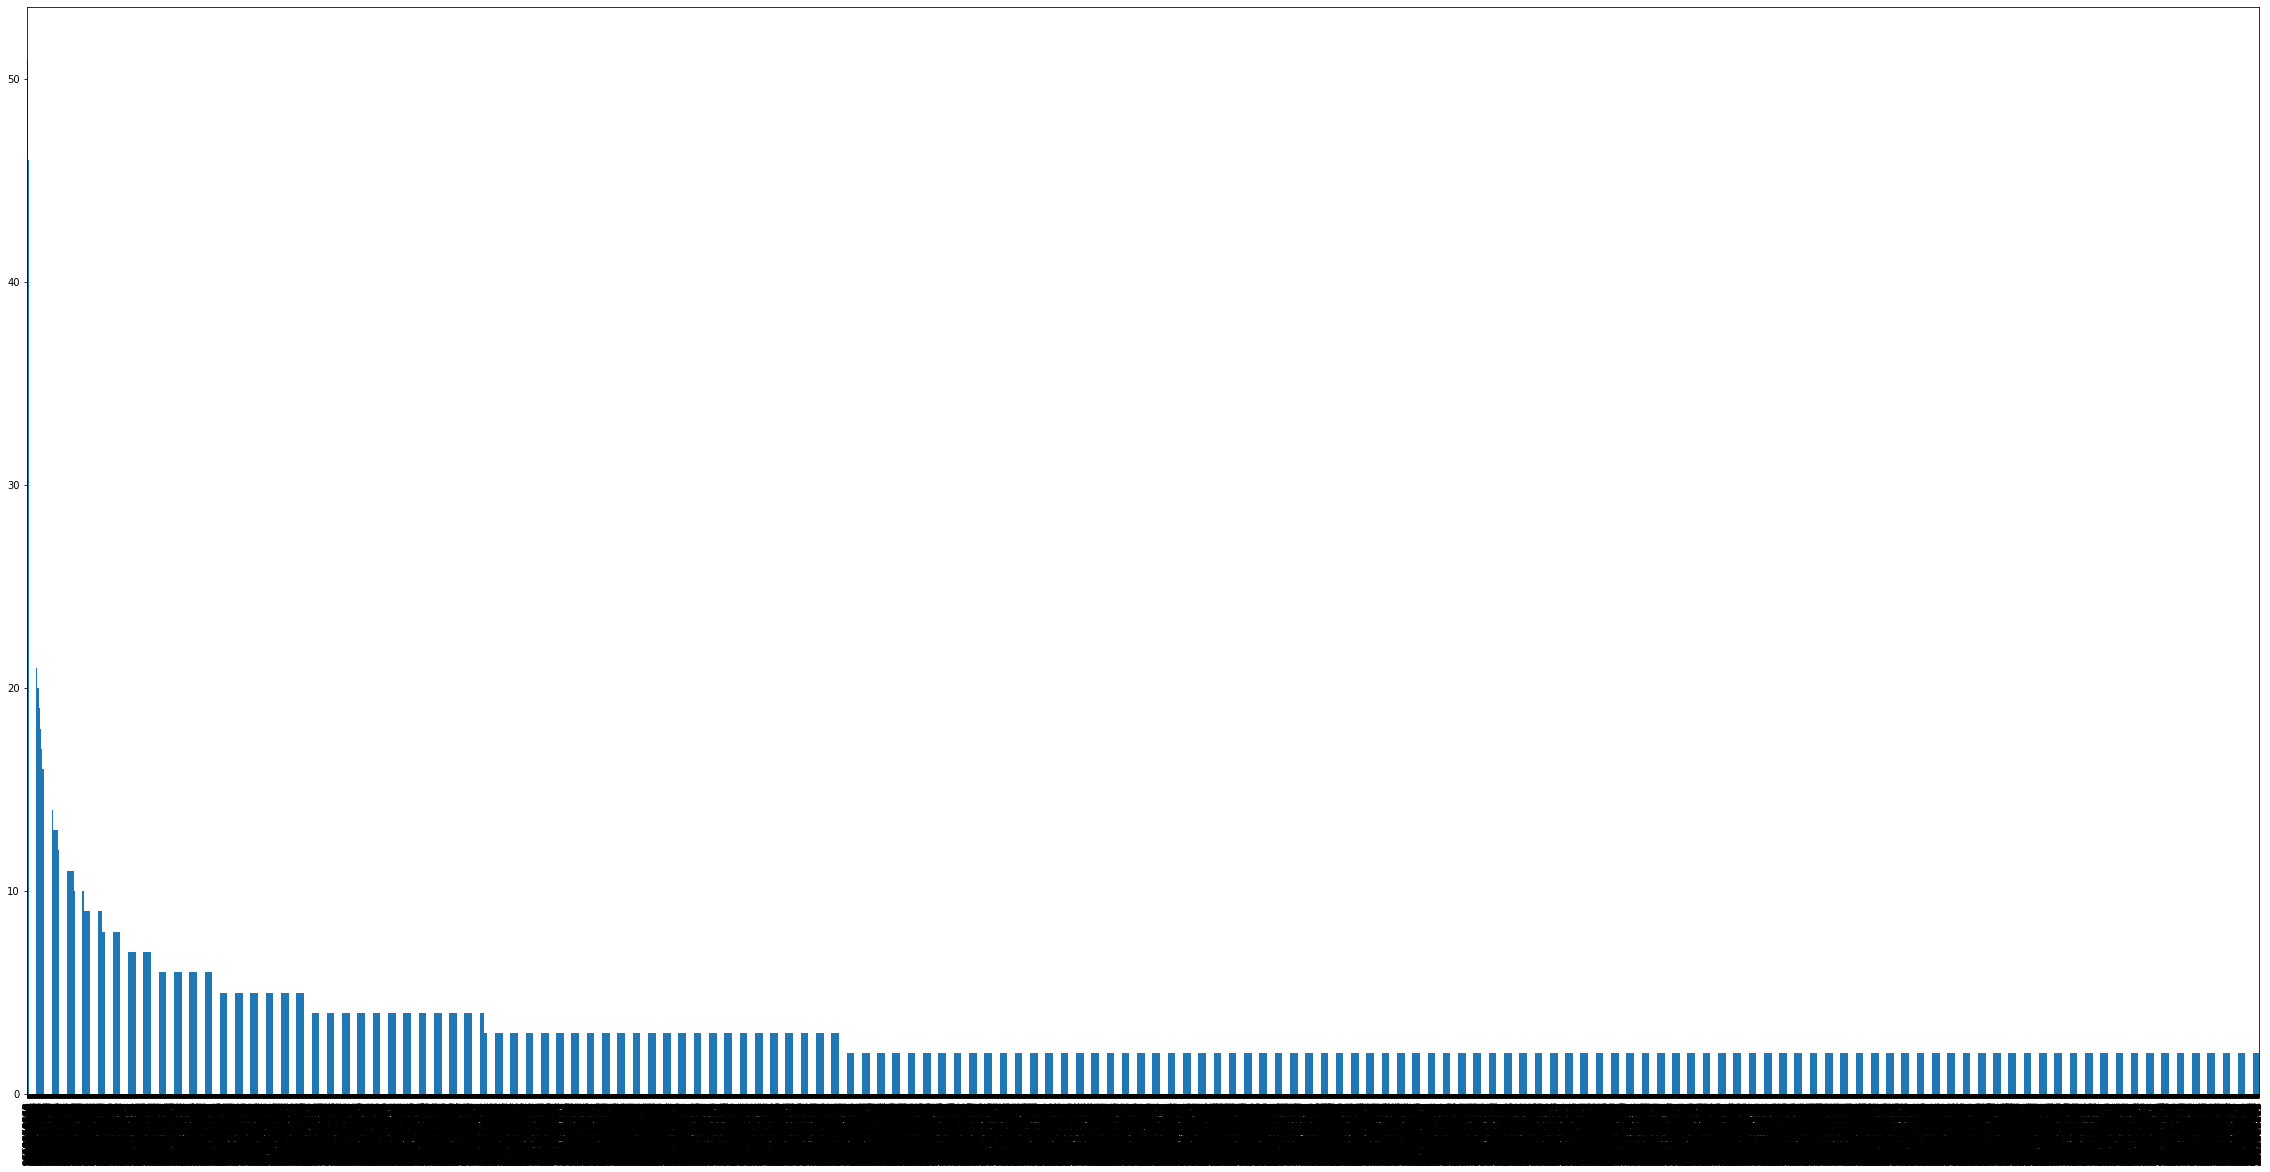

In [20]:
train_data.label_group.value_counts().plot.bar(figsize=(40,20))

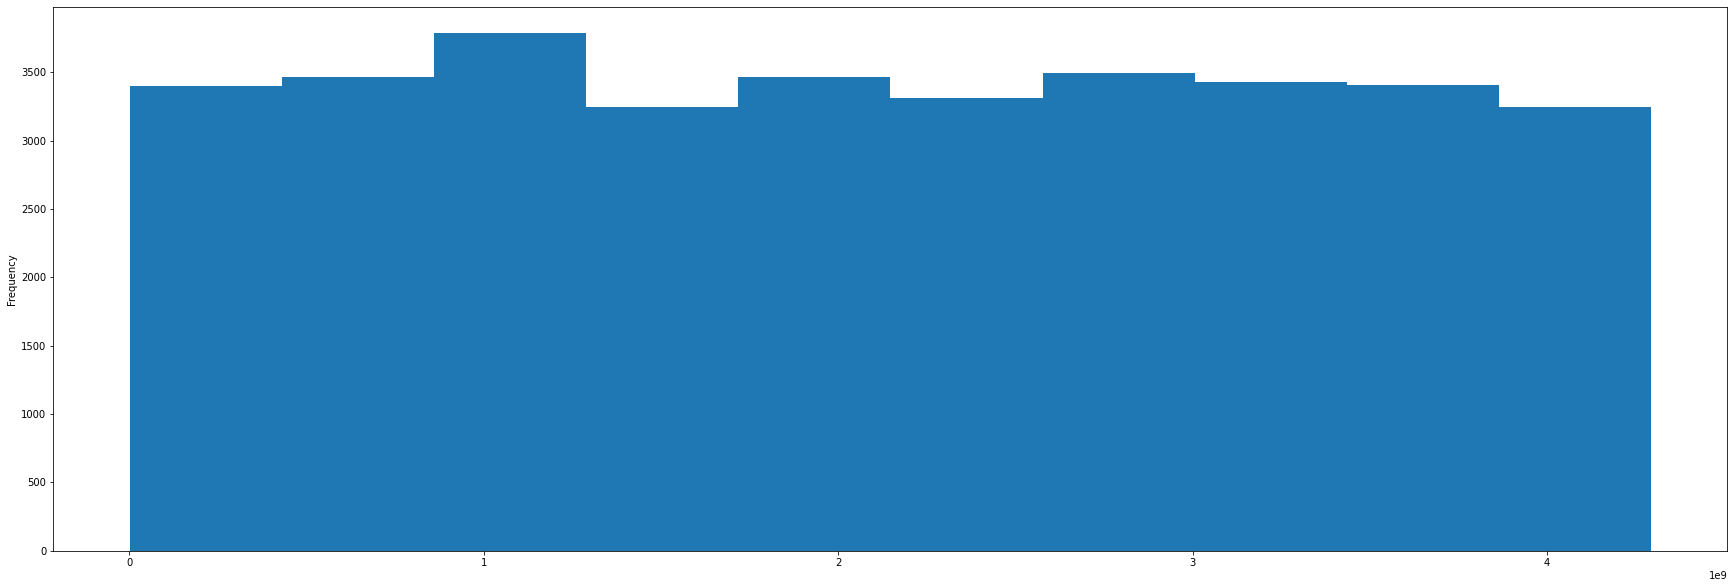

In [12]:
plt.figure(figsize=(30,10))
train_data.label_group.plot.hist()

In [13]:
train_data.label_group.value_counts()

994676122     51
159351600     51
562358068     51
3113678103    51
1163569239    51
              ..
3996065489     2
517023446      2
2101581536     2
3460538113     2
3927456083     2
Name: label_group, Length: 11014, dtype: int64

In [16]:
df = train_data.groupby('label_group').nunique()
df

,posting_id,image,image_phash,title
label_group,,,,
258047,3,3,3,3
297977,2,2,2,2
645628,12,12,11,11
801176,2,2,2,2
887886,2,2,2,2
...,...,...,...,...
4292154092,2,2,2,1
4292520070,11,9,1,11
4292939171,2,2,2,2
